# Install

In [1]:
!pip install python-bidi arabic-reshaper transformers dspy evaluate rouge_score
!pip install ibm-cos-sdk botocore
!pip install wordcloud seaborn qalsadi nltk camel-tools
pip install openai
!git clone https://github.com/openai/evals.git
%cd evals
!pip install .

  Using cached python_bidi-0.6.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
  Using cached arabic_reshaper-3.0.0-py3-none-any.whl.metadata (12 kB)
  Using cached dspy-2.5.28-py3-none-any.whl.metadata (41 kB)
  Using cached evaluate-0.4.3-py3-none-any.whl.metadata (9.2 kB)
  Using cached rouge_score-0.1.2.tar.gz (17 kB)
  Preparing metadata (setup.py) ... done
  Using cached backoff-2.2.1-py3-none-any.whl.metadata (14 kB)
  Using cached datasets-3.1.0-py3-none-any.whl.metadata (20 kB)
  Using cached diskcache-5.6.3-py3-none-any.whl.metadata (20 kB)
  Using cached json_repair-0.30.1-py3-none-any.whl.metadata (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.9/337.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

#Libraries

In [5]:
import re
import ibm_boto3
from botocore.client import Config
from bidi.algorithm import get_display  # To handle RTL text
import arabic_reshaper  # To reshape Arabic text
from collections import Counter
from transformers import AutoTokenizer, AutoModel, AutoModelForSeq2SeqLM
import torch
import dspy
import requests

from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from nltk.util import ngrams

import openai
import pandas as pd

from scipy.spatial.distance import cosine
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from statistics import mean


In [ ]:
# Function to remove Arabic diacritics
def remove_diacritics(text):
    arabic_diacritics = re.compile(r'[\u0610-\u061A\u064B-\u065F]')
    return re.sub(arabic_diacritics, '', text)


# Function to clean and enhance the text (spacing, punctuation, diacritics removal)
def clean_text(text):
    # Step 1: Remove diacritics
    text_without_diacritics = remove_diacritics(text)

    # Step 2: Remove excessive newlines and spaces
    cleaned_text = re.sub(r'\n+', ' ', text_without_diacritics)  # Replace newlines with spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()  # Remove extra spaces

    # Step 3: Fix spacing around punctuation (add space before and after Arabic punctuation)
    cleaned_text = re.sub(r'([،؛.])', r' \1 ', cleaned_text)  # Add spaces around punctuation
    cleaned_text = re.sub(r' +', ' ', cleaned_text)  # Remove multiple spaces

    # Step 4: Remove any English words or numbers (digits)
    cleaned_text = re.sub(r'[A-Za-z0-9]+', '', cleaned_text)  # Remove English letters and numbers

    return cleaned_text


In [ ]:
text_path = "/content/Allam_Dataset.txt"

# Open and read the contents of the text file
try:
    with open(text_path, "r", encoding="utf-8") as file:
        text_data = file.read()

    cleaned_fixed_text = clean_text(text_data)
    print(cleaned_fixed_text)

except Exception as e:
    print("Error occurred while reading the text file:", e)

قواعد اللغة العربية المبسطة-عبد اللطيف السعيد عبد اللطيف عبد الرحمن السعيد أقسام الكلم يقسم الكلام إلى اسم وفعل وحرف . الاسم: هو ما دل على معنى أو شياء ، مثل:التطور-الشجرة ، وهو أنواع: - اسم إنسان: أحمد – فاطمة . - اسم حيوان: غزال- حصان . - اسم نبات: شجرة- قمح . - اسم جماد: جدار- طاولة . اسماته: ا- يقبل دخول( ال)عليه:جدار- الجدار  قواعد اللغة العربية المبسطة-عبد اللطيف السعيد ب- يقبل دخول أداة الندااء عليه:يا أحمد! الفعل:هو ما دل على حدث أو عمل مرتبطا بالزمن . فإن كان الحدث ماضيا كان الفعل ماضيا ، مثل: (حضر) وإن كان الحدث حاضرا كان الفعل مضارعا ، مثل: (يحضر) وإن دل الفعل على طلب حدوث العمل كان الفعل فعل أمر ، مثل:(احضر) . الحرف:هو ما استعمل للربط بين السمااء والفعال أو بين أجزااء الجملة ، مثل: من- إلى . الاسماء الجامد والمشتق الجامد:هو السم الذي ل يؤخذ من غيره ، مثل(باب) . والمشتق:هو السم الذي يؤخذ من غيره ، مثل (مطل )ع من الطلوع .  قواعد اللغة العربية المبسطة-عبد اللطيف السعيد الاسم الجامد نوعان: ا- اسم ذات: هو السم الذي يدرك بالحواس ، مثل: شمس- نحلة ب- اسم معنى: هو السم الذي يدرك بال

## Exploratory Data Analysis

In [ ]:
# Calculate size of the text (in characters)
text_size = len(cleaned_fixed_text)

# Calculate the number of words in the text
word_count = len(cleaned_fixed_text.split())

print("\nSize of the text (in characters):", text_size)
print("Number of words in the text:", word_count)


Size of the text (in characters): 217339
Number of words in the text: 43139


In [ ]:
words = re.findall(r'\w+', cleaned_fixed_text)
word_counts = Counter(words)
print("Top 10 most common words:", word_counts.most_common(20))


Top 10 most common words: [('على', 778), ('في', 762), ('من', 624), ('أو', 372), ('إلى', 350), ('إذا', 297), ('مثال', 287), ('السعيد', 271), ('عبد', 257), ('وعلمة', 255), ('اللغة', 251), ('العربية', 249), ('اللطيف', 247), ('قواعد', 246), ('المبسطة', 246), ('أن', 240), ('ما', 238), ('فعل', 202), ('اسم', 196), ('الظاهرة', 190)]


In [ ]:
# Stop Word Filtering
stop_words = set(["و", "في", "من", "على", "إلى", "عن", "ما", "لم", "هذا", "أن", "هو", "هي","أو","إذا","يا"])
filtered_words = [word for word in words if word not in stop_words]
filtered_word_counts = Counter(filtered_words)
print("Top 20 most common words after stop word removal:", filtered_word_counts.most_common(20))

Top 20 most common words after stop word removal: [('مثال', 287), ('السعيد', 271), ('عبد', 257), ('وعلمة', 255), ('اللغة', 251), ('العربية', 249), ('اللطيف', 247), ('قواعد', 246), ('المبسطة', 246), ('فعل', 202), ('اسم', 196), ('الظاهرة', 190), ('محل', 184), ('منصوب', 170), ('كان', 166), ('مبني', 164), ('مثل', 162), ('به', 153), ('مفعول', 152), ('الفعل', 151)]


In [ ]:
#N-grams Analysis (Bigrams)
bigrams = list(ngrams(filtered_words, 2))
bigram_counts = Counter(bigrams)
print("Top 10 bigrams:", bigram_counts.most_common(10))

Top 10 bigrams: [(('اللغة', 'العربية'), 249), (('عبد', 'اللطيف'), 247), (('قواعد', 'اللغة'), 246), (('العربية', 'المبسطة'), 246), (('المبسطة', 'عبد'), 246), (('اللطيف', 'السعيد'), 246), (('وعلمة', 'نصبه'), 117), (('نصبه', 'الفتحة'), 102), (('منصوب', 'وعلمة'), 99), (('الفتحة', 'الظاهرة'), 99)]


In [ ]:
#N-grams Analysis (Trigrams)
trigrams = list(ngrams(filtered_words, 3))
trigram_counts = Counter(trigrams)
print("Top 10 bigrams:", trigram_counts.most_common(10))

Top 10 bigrams: [(('قواعد', 'اللغة', 'العربية'), 246), (('اللغة', 'العربية', 'المبسطة'), 246), (('العربية', 'المبسطة', 'عبد'), 246), (('المبسطة', 'عبد', 'اللطيف'), 246), (('عبد', 'اللطيف', 'السعيد'), 246), (('وعلمة', 'نصبه', 'الفتحة'), 102), (('منصوب', 'وعلمة', 'نصبه'), 98), (('نصبه', 'الفتحة', 'الظاهرة'), 93), (('مرفوع', 'وعلمة', 'رفعه'), 88), (('وعلمة', 'رفعه', 'الضمة'), 70)]


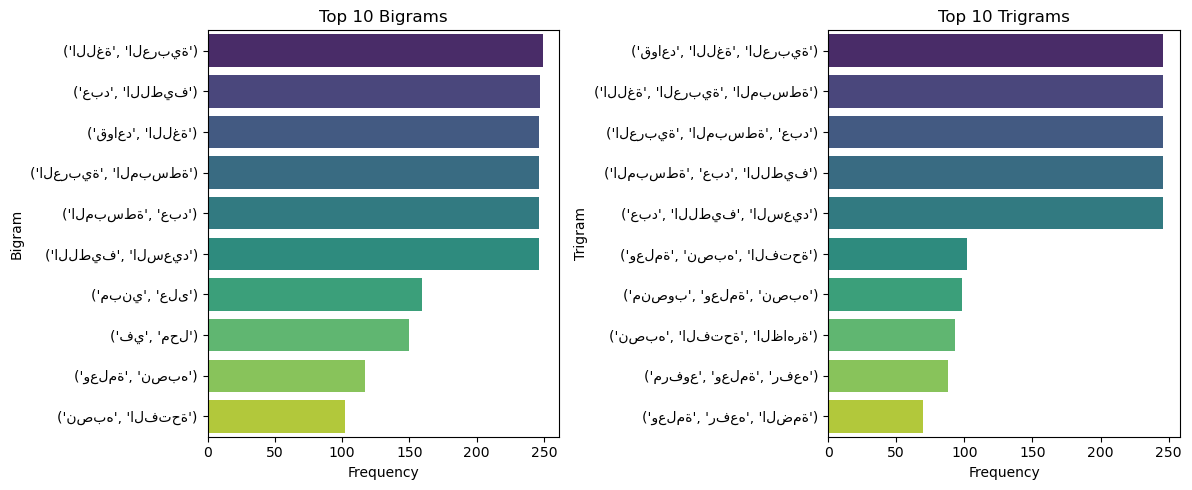

In [ ]:
# Bigram and Trigram Visualization
bigram_counts = Counter(ngrams(words, 2))
trigram_counts = Counter(ngrams(words, 3))

# Convert to DataFrame
df_bigrams = pd.DataFrame(bigram_counts.most_common(10), columns=['Bigram', 'Frequency'])
df_trigrams = pd.DataFrame(trigram_counts.most_common(10), columns=['Trigram', 'Frequency'])

# Plot Bigrams and Trigrams
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Frequency', y='Bigram', data=df_bigrams, palette='viridis')
plt.title("Top 10 Bigrams")

plt.subplot(1, 2, 2)
sns.barplot(x='Frequency', y='Trigram', data=df_trigrams, palette='viridis')
plt.title("Top 10 Trigrams")

plt.tight_layout()
plt.show()

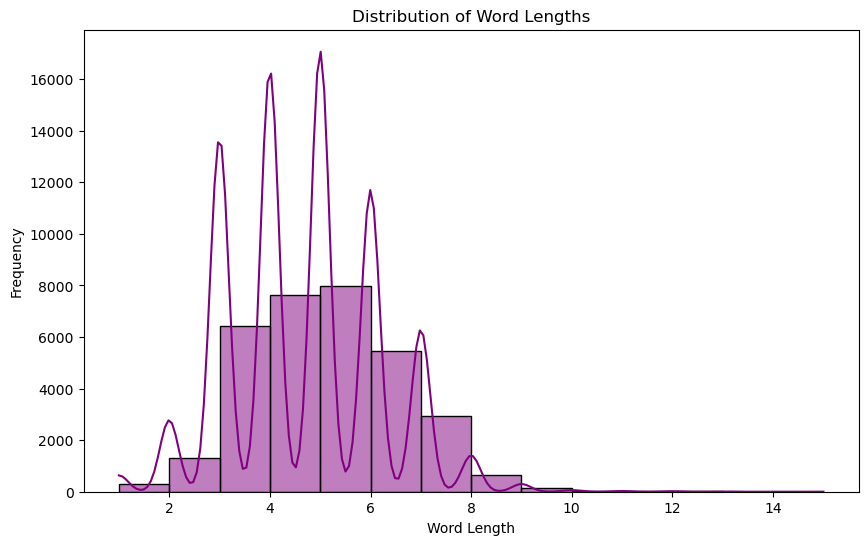

In [ ]:
# Length Distribution of Words
word_lengths = [len(word) for word in filtered_words]
plt.figure(figsize=(10, 6))

# Set bar color to purple and KDE line color to black
sns.histplot(word_lengths, bins=range(1, max(word_lengths) + 1), kde=True, color='purple', line_kws={'color': 'black'})

plt.title("Distribution of Word Lengths")
plt.xlabel("Word Length")
plt.ylabel("Frequency")
plt.show()

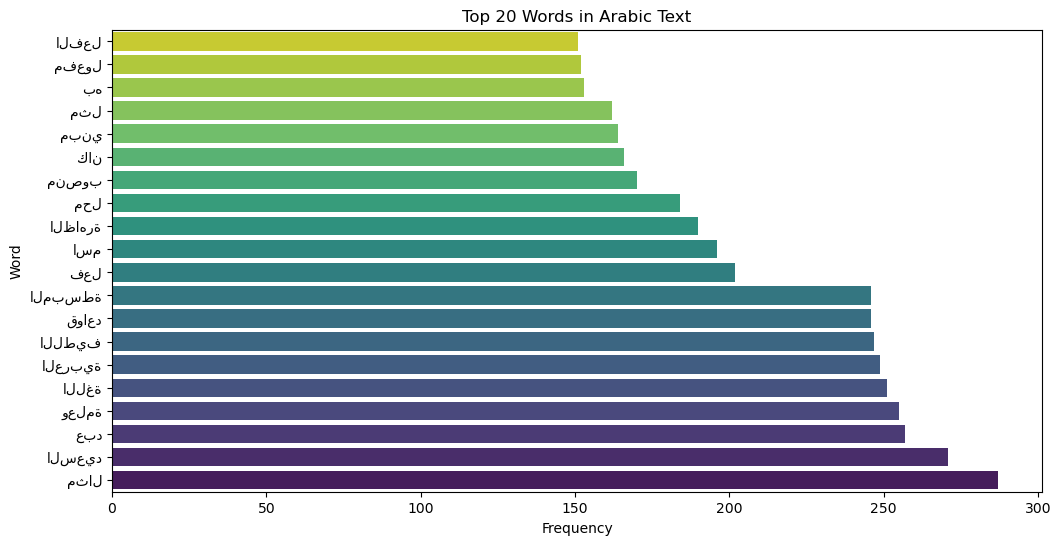

In [ ]:
# Bar plot to visualize the top words
df_word_counts = pd.DataFrame(filtered_word_counts.most_common(20), columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=df_word_counts, palette='viridis')
plt.gca().invert_yaxis()  # Corrects the direction for Arabic text by reversing the order
plt.title("Top 20 Words in Arabic Text")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

## Preprocessing

In [ ]:
def get_cleaned_text(cos_client, bucket, object_key):
    try:
        response = cos_client.get_object(Bucket=bucket, Key=object_key)
        text_data = response['Body'].read().decode('utf-8')
        return clean_text(text_data)
    except Exception as e:
        print("Error occurred while retrieving the text file:", e)
        return None

def get_embeddings(text, model, tokenizer, max_length=256):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")
model = AutoModel.from_pretrained("aubmindlab/bert-base-arabertv02")

max_length = 512
inputs = tokenizer(cleaned_fixed_text, return_tensors="pt", truncation=True, max_length=max_length, padding=True)

with torch.no_grad():
    outputs = model(**inputs)

embeddings = outputs.last_hidden_state.mean(dim=1)
print("Embedding shape:", embeddings.shape)

Embedding shape: torch.Size([1, 768])


In [ ]:
# Custom Retriever class using embeddings
class CustomRetriever:
    def __init__(self, tokenizer, model, max_length=512):
        self.tokenizer = tokenizer
        self.model = model
        self.max_length = max_length
        self.embeddings = None

    def tokenize_and_embed(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, max_length=self.max_length, padding=True)
        with torch.no_grad():
            outputs = self.model(**inputs)
        return outputs.last_hidden_state.mean(dim=1)

    def set_corpus_embeddings(self, corpus):
        """Precomputes and stores embeddings for a corpus."""
        self.embeddings = []
        for passage in corpus:
            self.embeddings.append(self.tokenize_and_embed(passage))
        self.embeddings = torch.vstack(self.embeddings)

    def retrieve(self, question):
        """Generates query embeddings and retrieves top matching passages."""
        query_embedding = self.tokenize_and_embed(question)
        similarities = torch.nn.functional.cosine_similarity(query_embedding, self.embeddings)

        # Adjust top_k to handle fewer passages than k
        top_k_count = min(3, len(self.embeddings))  # Use min to avoid index out of range
        top_k = similarities.topk(top_k_count).indices
        return top_k

In [ ]:
# IAM Token generation for IBM Cloud API
def get_iam_token(api_key):
    auth_url = "https://iam.cloud.ibm.com/identity/token"
    response = requests.post(auth_url, data={
        'apikey': api_key,
        'grant_type': 'urn:ibm:params:oauth:grant-type:apikey'
    }, headers={
        'Content-Type': 'application/x-www-form-urlencoded',
        'Accept': 'application/json'
    })
    if response.status_code == 200:
        return response.json()["access_token"]
    else:
        raise Exception(f"Error: {response.status_code} - {response.text}")



In [ ]:
class GenerateAnswer:
    def __call__(self, context, question, iam_token):

        # Examples to demonstrate the structure the model should follow
        examples = """

        Q: ماهي اقسام الكلام؟

        A: كان علاء الدين شاباً يحب المغامرات والقصص، وفي أحد الأيام، أمسك بمصباحه السحري وتمنى أن يطير به إلى عالم الكلمات والحروف. فإذا به يرتفع في الهواء، حاملاً علاء الدين في رحلة عبر السماء.
        وصل علاء الدين إلى قصرٍ بديع، كان مبنيّاً من كلمات متلألئة. وعندما دخل، وجد ثلاثة أصدقاء يعيشون فيه: الأول كان اسمه "الاسم"، والثاني "الفعل"، والثالث "الحرف".
        قال "الاسم": "أنا المسؤول عن كل الأسماء التي تراها حولك، من إنسان إلى شجرة، إلى كتاب، كل شيء له اسم أعطيه إياه." أما "الفعل"، فقال: "وأنا أعطي الأشياء القدرة على الحركة والعمل، فأقول إن أحمد يقرأ، أو الطائرة تطير." وبينما كانا يتحدثان، قال "الحرف": "أنا أربط الكلمات ببعضها لتصبح جملة ذات معنى، فأنا كالغراء الذي يجمع الحروف معاً."
        جلس علاء الدين مع أصدقائه الجدد، وتحدثوا طويلاً عن الكلمات والجمل. فهم علاء الدين أن الكلمات تشبه قطع الليجو، وعندما نركبها معاً نحصل على صورة كاملة. وأن "الاسم" هو الأساس، و"الفعل" هو الحركة، و"الحرف" هو الرابط بينهما.
        عاد علاء الدين إلى أرضه وهو يحمل في قلبه الكثير من المعرفة عن الكلمات. وتذكر دائماً أن الكلمات هي أقوى سلاح لدينا، وأن علينا أن نستخدمها بحكمة وبناء.
        هل أعجبتك القصة يا صغيري؟ تذكر دائماً أن تقرأ الكثير من الكتب، لأن القراءة توسع مداركك وتزيد.

        """

        # Characters list for storytelling context
        characters_list = """
        - "شهرزاد": الحكواتية الشهيرة التي تروي القصص بمهارة لتسحر الملك شهريار، يمكنها أن تروي للأطفال قصة جديدة لتوضيح المفهوم.
        - "شهريار": الملك الذي يستمع للقصص، ويمكن أن يمثل الطفل الذي يريد معرفة المزيد ويطرح الأسئلة.
        - "السندباد البحري": البحار الذي يسافر إلى أماكن بعيدة ويواجه تحديات مختلفة، يمكنه أخذ الأطفال في مغامرات لفهم المفاهيم الصعبة.
        - "علاء الدين": الشاب الذي يملك المصباح السحري، يمكنه استخدام الجني لمساعدة الأطفال على فهم الأمور السحرية أو الغامضة.
        - "مرجانة": الفتاة الذكية التي تساعد علي بابا، يمكنها أن تقدم حلولًا سريعة وأفكارًا مفيدة.
        """

        # Instructions for how the response should be generated
        instructions = f"""
        أنت معلم للأطفال وتريد أن تجعل عملية التعلم مشوقة ومليئة بالخيال. أجب على السؤال باستخدام أسلوب سرد يشبه قصص ألف ليلة وليلة.
        اختر من الشخصيات التالية لتساعدك في الشرح:
        {characters_list}
        احرص على:
        - استخدام شخصية أو أكثر لجعل الشرح ممتعًا.
        - تقديم مغامرة بسيطة مع وصف المكان والأحداث لجعل المشهد حيويًا وشيقًا.
        - التأكد من أن الشرح مناسب للأطفال بين 6 و12 سنة باستخدام جمل قصيرة وكلمات بسيطة.
        - إشراك الطفل في القصة عبر طرح أسئلة، مثل: "هل ترى الفرق الآن؟" أو "هل ترغب في استكشاف المزيد؟".
        - إنهاء القصة بنبرة إيجابية ومشجعة.

         هذا مثال يجب أن تقتدي به عند الإجابة:
        {examples}
        """

        # Construct the prompt with the retrieved context, question, and instructions
        input_text = f"""
        السؤال: {question}
        \nالمعلومات المرجعية:\n{context}
        \nالتعليمات:\n{instructions}
        \nالإجابة:"""

        # API endpoint and model settings
        self.url = "https://eu-de.ml.cloud.ibm.com/ml/v1/text/generation?version=2023-05-29"
        self.model_id = "sdaia/allam-1-13b-instruct"
        self.project_id = "ed6b7fdf-5e8e-4bbd-8f93-356d126fc962"
        self.headers = {
            "Accept": "application/json",
            "Content-Type": "application/json",
            "Authorization": f"Bearer {iam_token}"
        }

        # Prepare the request body
        body = {
            "input": input_text,
            "parameters": {
                "decoding_method": "sample",
                "max_new_tokens": 900,
                "temperature": 0.7,  # Reduced temperature for more predictable output
                "top_k": 50,         # Lower top_k to make it more deterministic
                "top_p": 0.9,
                "repetition_penalty": 1.15
            },
            "model_id": self.model_id,
            "project_id": self.project_id
        }

        # Make the API request
        response = requests.post(self.url, headers=self.headers, json=body)

        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()

            # Debugging: Print the entire response from the model
            print("[DEBUG] Response:", response)

            # Extract generated text
            if "results" in data and len(data["results"]) > 0:
                generated_text = data["results"][0].get("generated_text", "No generated text found")
                print("Generated Text:\n", generated_text)
                return generated_text
            else:
                print("No generated text found.")
                return "No generated text found."
        else:
            print(f"Error: {response.status_code} - {response.text}")
            return f"Error: {response.status_code} - {response.text}"


In [ ]:
class ArabicRAG:
    def __init__(self, corpus, num_passages=3):
        # Set corpus as an attribute for easy access
        self.corpus = corpus
        self.num_passages = num_passages

        # Initialize the retriever with AraBERT
        max_length=10000
        self.retriever = CustomRetriever(tokenizer, model, max_length)
        self.retriever.set_corpus_embeddings(self.corpus)  # Precompute embeddings for the corpus
        self.generate_answer = GenerateAnswer()  # Initialize GenerateAnswer class

    def forward(self, question, iam_token):
        """
        Retrieve relevant context based on the user question and generate an answer.

        Parameters:
        - question: The question provided by the user.
        - iam_token: The IBM Cloud IAM token for API authorization.

        Returns:
        - The generated answer from the model.
        """

        # Retrieve the most relevant passages based on the question
        relevant_indices = self.retriever.retrieve(question)

        # Use retrieved indices to get relevant context from the corpus
        context = "\n".join([self.corpus[i] for i in relevant_indices])

        # Generate the answer using the retrieved context and question
        prediction = self.generate_answer(context=context, question=question, iam_token=iam_token)

        return prediction


In [ ]:
# Define a function to get user input dynamically

api_key = 'l9cHEdqwQcXTGQ5toy6w02ogU8KR89g3w94ojrI8mgN1'
iam_token = get_iam_token(api_key)

passages = cleaned_fixed_text.split(". ")  # Splitting by sentence for demonstration

In [ ]:
# Initialize the ArabicRAG model with the split passages
compiled_rag = ArabicRAG(corpus=passages, num_passages=3)


In [ ]:
# Get user input for the question
user_question = input("Enter your question in Arabic: ")

# Generate the answer using the model
response = compiled_rag.forward(user_question, iam_token)

if len(response.strip()) < 20:  # Assuming a good answer should be at least 20 characters
    print("The generated answer was too short, retrying...")
    response = compiled_rag.forward(user_question, iam_token)

print(response)

Enter your question in Arabic: ماهو اسلوب الاستثناء؟
[DEBUG] Model Input: 
        السؤال: ماهو اسلوب الاستثناء؟
        
المعلومات المرجعية:
- نجح اسبعة طلب من صفنا 
هل:حرف تحضيض 
خبرا:هذا الطالب مجدا 
        
التعليمات:

        أنت معلم للأطفال وتريد أن تجعل عملية التعلم مشوقة ومليئة بالخيال. أجب على السؤال باستخدام أسلوب سرد يشبه قصص ألف ليلة وليلة.
        اختر من الشخصيات التالية لتساعدك في الشرح:
        
        - "شهرزاد": الحكواتية الشهيرة التي تروي القصص بمهارة لتسحر الملك شهريار، يمكنها أن تروي للأطفال قصة جديدة لتوضيح المفهوم.
        - "شهريار": الملك الذي يستمع للقصص، ويمكن أن يمثل الطفل الذي يريد معرفة المزيد ويطرح الأسئلة.
        - "السندباد البحري": البحار الذي يسافر إلى أماكن بعيدة ويواجه تحديات مختلفة، يمكنه أخذ الأطفال في مغامرات لفهم المفاهيم الصعبة.
        - "علاء الدين": الشاب الذي يملك المصباح السحري، يمكنه استخدام الجني لمساعدة الأطفال على فهم الأمور السحرية أو الغامضة.
        - "مرجانة": الفتاة الذكية التي تساعد علي بابا، يمكنها أن تقدم حلولًا سريعة وأفكا

## Evaluation

### Test Data

In [23]:
queres_=["ماهو الفاعل وماهو المفعول به؟",
            "اشرح لي اقسام الكلام ",
            " ما الفرق بين جمع المذكر السالم والمؤنث السالم",
            " هل اللام تنطق بالحروف الشمسية ام الحروف القمرية؟",
            " ماذا يعني الحرف الساكن ",
        "ماهي اداه الشرط وماهو جواب الشرط",
        "ماهي الحروف الناسخة ؟",
        "ماهو الضمير؟",
        "اشرح لي اسلوب النداء",
        "اشرح لي ظروف الزمان والمكان",
        "في جملة النباتات غذاء للانسان هل هي جملة اسمية ام جملة فعلية؟",
         "ماهي حروف العلة؟",
         "اشرح لي المبني للمجهول",
         "ماهو الفرق بين لا الناهية ولا النافية",
         "ماهو السجع",
         "ما الفرق بين المشبه والمشبه به ",
         "ما الفرق بين همزه الوصل وهمزة القطع",
         "ماهي انواع التمييز باللغة العربية؟",
         "اشرح اسلوب التعجب",
         "ما الفرق بين جملة الحال وجملة الصلة",
         "ماهو اسلوب الاستثناء"
        ]

In [17]:
predictions = [
    "في يوم من الأيام، جلست شهرزاد لتروي للملك شهريار قصة عن تاجر حكيم يُدعى زيد. كان زيد يعيش في بغداد القديمة، وذات يوم قرر أن يرسم لوحة جميلة تُظهر السوق الكبير"
    "بينما كان زيد يرسم، جاءت طفلة وسألته: \"من يقوم بالرسم؟\" فأجاب زيد: \"أنا، زيد، أقوم بالرسم، لذا فأنا الفاعل.\""
    "ثم أشارت الطفلة إلى اللوحة وقالت: \"وما هذا؟\" فأجاب زيد: \"هذه هي اللوحة، وهي المفعول به، لأنها الشيء الذي يقع عليه الفعل.\""
    "فهم شهريار الأمر وقال: \"إذن الفاعل هو من يقوم بالفعل، والمفعول به هو ما يقع عليه الفعل",

    "في ليلة هادئة مليئة بالنجوم، جلست شهرزاد في ساحة القصر وأحاط بها الأطفال. قالت لهم: 'سأخذكم اليوم إلى مدينة عجيبة، حيث يعيش العمال والنساء في تناغم تام.' وما أن أغمض الأطفال أعينهم حتى وجدوا أنفسهم في مدينة مليئة بالبيوت الجميلة والأسواق المزدحمة. التقوا هناك بالحكيم أبو القواع الذي قال لهم: 'يا أطفال، اليوم سنتعلم عن جمع المذكر السالم وجمع المؤنث السالم.' كتب أبو القواعد على لوحٍ أمامه: 'المعلمون يعملون، والمعلمات يدرسن.' سألت لينا: 'لماذا قلت المعلمون والمعلمات؟' أجاب الحكيم مبتسمًا: 'جمع المذكر السالم نستخدمه عندما نجمع الكلمات المذكرة، مثل المعلمون، ونضيف ون أو ين إلى المفرد. أما جمع المؤنث السالم فنستخدمه عندما نجمع الكلمات المؤنثة مثل المعلمات، ونضيف ات إلى المفرد.' فجأة، بدأ سكان المدينة يصفقون، وقالت شهرزاد: 'أحسنتم يا أبطال! الآن تعرفتم على سر الجمع، المذكر للمذكر والمؤنث للمؤنث.' ثم عادت الأطفال إلى زمنهم وهم يرددون: 'المعلمون، المعلمات، نجمعهم هكذا بكل سهولة.'",

    "رحلة سندباد مع اللام السحرية. أيها المسافرون الأعزاء، أهلا وسهلا في سفينتي. سأحكي لكم اليوم قصة غريبة عشتها في إحدى رحلاتي، قصة عن اللام السحرية. اكتشفت أن اللام لها صديقان: أحدهما يخفيها (الحروف الشمسية) والآخر يظهرها (الحروف القمرية). الحروف الشمسية تحب أن 'تأكل' اللام وتخفيها. وكأنها وحوش صغيرة تأكل اللام ولا تترك لها أثراً. مثلاً الشمس. على عكس الحروف الشمسية، تحب الحروف القمرية أصدقاء لللام يساعدونها على الظهور مثل كلمة القمر",

    "في إحدى مغامراته البحرية، قرر السندباد الإبحار إلى جزيرة غامضة تُسمى 'جزيرة الحروف الساكنة'. هذه الجزيرة كانت مليئة بالأشجار والأنهار، لكن هناك شيء مميز في هذه الجزيرة: كل الحروف التي تعيش فيها لا تحب الحركة، فهي هادئة وساكنة. عندما وصل السندباد إلى الجزيرة، قال: 'في هذه الجزيرة، الحروف الساكنة تختبئ في الكلمات بهدوء. على سبيل المثال، في كلمة 'شجرة'، الحرف 'ش' يبقى ساكنًا ولا يتحرك كثيرًا. لنقم بلعبة! حاول العثور على الحروف الساكنة في هذه الكلمات: 'سوق'، 'كتاب'، و'شجرة'. ابحث عن الحروف الساكنة في كلمات أخرى مثل 'مكتب'، 'مدرسة'، و'قلم'. هل يمكنك كتابة جملة تحتوي على الحروف الساكنة؟ إذا وجدت جميع الحروف الساكنة، سيعطيك سندباد خريطة سرية تقودك إلى كنز مخفي في الجزيرة"
]

In [19]:
predictions_2 = [
    "في عالمنا المليء بالألوان والجمال، تعيش شهرزاد وشهريار معًا بسعادة وهناء. كانت شهرزاد حكواتية رائعة تستطيع رواية أجمل الحكايات لتسلية شهريار وإلهامه. وفي يوم من الأيام، قرر شهريار الاستماع لقصة جديدة تسحر عقله وتأخذه في عالم مليء بالمغامرات والخيال. جلست شهرزاد تحت ضوء القمر وبدأت تحكي لشهريار حكاية عن أدوات الشرط وجوابه في لغتنا الجميلة. قالت: 'يا شهريار العزيز، تخيل أنك تريد لعب لعبة مسلية مع أصدقائك، وعليك اختيار فريقين: الفريق الفائز يحصل على جائزة قيمة. ولكن قبل ذلك، تحتاج إلى تحديد الشروط والقواعد الخاصة باللعبة حتى يتم اللعب بشكل عادل ومنصف.' هنا يأتي دور أدوات الشرط في هذه اللعبة الممتعة. فكما تعلم يا عزيزي، تتكون الجملة الشرطية من جزأين رئيسيين هما أداة الشرط وجوابه. أداة الشرط تشير إلى الحالة المطلوبة لتحقيق الفوز، بينما جوابه يوضح ماذا سيحدث إذا تحققت تلك الحالة. فلنتخيل مثلاً: إذا درس الطالب بجد واجتهاد (أداة الشرط)، فإنه سيضمن النجاح والتفوق (جوابه). هكذا تكون الجملة الشرطية واضحة وسهلة الفهم. تذكر يا شهريار، عندما تستمع إلى حكايات أخرى وتستكشف معاني الجمل المختلفة، ستجد نفسك تفهم العالم من حولك بطريقة أفضل وأكثر متعة. فهل تود سماع المزيد من الحكايات الشيقة لتعلم المزيد؟ هل استمتعت بهذه الرحلة الخيالية يا صغيري؟ أتمنى أن يكون الدرس قد أصبح واضحاً لك. لا تنسَ أن تمارس قراءة القصص والكتب لزيادة معرفتك وتنمية مهاراتك اللغوية. استمر في رحلتك نحو العلم والتعلم ولا تتوقف أبداً!",

    "شهرزاد وعلاء الدين يأخذانك في مغامرة شيقة لفهم الحروف الناسخة! في قديم الزمان، كانت هناك مملكة سحرية حيث عاش الأصدقاء الثلاثة: الاسم والفعل والحرف. كانوا يعرفون بكل أسرار اللغة العربية ويعملون معًا لجعل الكلمات تتدفق بسلاسة وجمال. كان الاسم ملك المملكة وكان مسؤولاً عن تحديد هوية الأشياء والكائنات من حولنا. إنه يعرف أسماء الأشجار والجبال والحيوانات والناس وكل ما يوجد في العالم من حوله. أما الفعل فكان بطل المملكة الحقيقي. بفضل قوته الخارقة، يمكن للفعل تحويل السكون إلى حركة والحياة إلى عمل. عندما يقول 'قرأ'، يمكننا تخيل شخص يفتح كتابه ويبدأ بالقراءة. وعندما يقول 'كتب'، نرى يداً تمسك بقلم وتبدأ بكتابة الأحرف والكلمات على الورق. ولكن ماذا لو أردنا توصيل الأفكار وربطها ببعضها البعض بطريقة سلسة وجميلة؟ هنا يأتي دور الحرف. الحرف يشبه الغراء القوي الذي يربط الكلمات ويجعل الجمل متناسقة ومترابطة. بفضل الحرف نستطيع التعبير عما يدور بخاطرنا ونقل أفكارنا بوضوح. وفي يوم من الأيام، زار الملك الصغير علاء الدين هذه المملكة الساحرة والتقى بالأصدقاء الثلاثة. استمع بانتباه لقصتهم وتعلم منهم عن أهمية الكلمات وكيف تعمل معًا لخلق النصوص الجميلة والمؤثرة. عندما عدت إلى مملكتك الخاصة يا صغيري، لا تنسى مشاركة ما تعلمته مع أصدقائك وإخوتك الصغار. اجعل كلماتك قوية وواضحة واستخدمها لبناء مستقبل مشرق لنفسك ولمن حولك. هل رأيت كيف يعمل الأصدقاء الثلاثة معًا لإثراء لغتنا وجعلها جميلة وسهلة الفهم؟ تذكر دائمًا أن تستكشف المزيد وتعرف الجديد في عالم اللغة الساحر!",

    "كان شهرزاد وسهرير يجلسان تحت ضوء القمر، يحكيان قصصًا شيقة وممتعة لبعضهما البعض. كانت شهرزاد تقص الحكايات بصوتها العذب، بينما يستمع سهرير بدهشة واهتمام. في إحدى الليالي، حكت شهرزاد لسهرير قصة عن الضمير. قالت له: 'يا ولدي العزيز، تخيل نفسك تلعب لعبة الاختباء والبحث. تختبئ خلف الأشجار والزهور، ثم يبحث عنك صديقك حتى يجد مكانك.' أومأ سهرير برأسه وابتسم، فهو يعرف هذه اللعبة جيداً. تابعت شهرزاد قائلةً: 'تماماً كما تبحث عن صديقك عندما يختبئ، يحتاج الناس أيضاً للبحث عن بعضهم البعض لكي يفهموا مشاعرهم ونواياهم. هنا يأتي دور الضمير.' استفسر سهرير بفضول قائلاً: 'ما هو الضمير إذاً؟ وكيف يمكنني فهمه؟' ابتسمت شهرزاد وأجابت: 'الضمير هو جزء منك يساعدك على اتخاذ القرارات الصحيحة ومعرفة ما هو صحيح وما هو خطأ. إنه صوت داخلي يوجهك ويساعدك على التصرف بنزاهة واحترام للآخرين.' فكر سهرير قليلاً وسأل مجدداً: 'كيف يمكن للمرء تطوير ضميره إذا لم يكن قوياً بما يكفي؟' ضحكت شهرزاد وقالت: 'لا تقلق يا بني، فالضمير يتطور كلما تعلم الإنسان واستمع لتجارب الآخرين. اقرأ القصص والكتب وتعلم منها، فالتعلم يساعد على تنمية ضمير قوي ومستنير.' سأل سهرير بشغف: 'وكيف يمكنني تطبيق ذلك في حياتي اليومية؟ كيف يمكنني استخدام ضميري لاتخاذ قرارات جيدة؟' أجابته شهرزاد وهي تنظر إليه بعينين دافئتين: 'عندما تواجه قراراً صعباً، توقف للحظة واسأل نفسك: ماذا كنت سأفعل لو كان صديقي يشاهدني؟ إذا شعرت بأن قرارك سيكون مقبولاً أمام صديق جيد لك، فهذا يعني أنه الخيار الصحيح.' تنهد سهرير برضا وقال: 'شكراً لك يا شهرزاد، لقد ساعدتني قصتك على فهم الضمير وأهميته في حياتنا.' فرحت شهرزاد بنجاحها في إيصال الفكرة لسهرير وقالت: 'أنت تلميذ ذكي وذو قلب طيب، وأنا واثقة بأنك ستستخدم ضميرك بشكل ممتاز في المستقبل.' ابتسم سهرير بسعادة وامتلأ قلبه بالأمل، فقد أدرك أهمية الضمير وكيفية استخدامه لبناء حياة مليئة بالحب والاحترام للجميع. وهكذا، انتهت الليلة الجميلة بين شهرزاد وسهرير بقصة رائعة وحكمة قيمة حول الضمير وتأثيره العميق في حياتنا. هل تود سماع قصة أخرى يا عزيزي الصغير؟ أم تفضل اللعب بألعابك المفضلة والاستمتاع بيوم جميل؟ القرار بيدك! تذكر دائمًا أن تستخدم ضميرك كمرشد في حياتك، ولا تتردد في طلب المساعدة والنصيحة من الأشخاص الذين تثق بهم. استمتع بيوم مليء بالمرح والتعلم!",

    "كان يا مكان في بلاد العرب القديمة، حيث كانت شهرزاد تحكي لشهريار قصصاً ممتعة قبل النوم. وفي إحدى الليالي الساحرة، قررت شهرزاد أن تروى لشهريار قصة عن المنادى وكيف يعمل. في زمن بعيد جداً، كان هناك صياد يدعى 'سعيد' يعيش بالقرب من البحر. كان سعيد صياداً ماهراً ويحب صيد الأسماك الكبيرة والجميلة. في يوم من الأيام، ذهب سعيد إلى البحر كعادته ليصطاد بعض الأسماك لإطعام عائلته الصغيرة. بينما كان سعيد يجذف قاربه الصغير ويبحث عن السمك المناسب لصيده، سمع صوتاً غريباً ينادي باسمه قائلاً: 'يا سعيد! يا سعيد!' التفت سعيد حوله ليرى مصدر الصوت، لكنه لم يجد أحداً معه على القارب. تعجب سعيد وسأل نفسه: ما هذا الصوت الغريب ولماذا يناديني باسمي؟ قرر سعيد أن يستمر في التجذيف والبحث عن مصدر الصوت الغريب. وبعد فترة قصيرة من البحث، لاحظ وجود طائر غريب يجلس فوق صخرة كبيرة قريبة منه. اقترب سعيد من الصخرة ورأى الطائر الجميل بألوان زاهية وجناحين كبيرين. عندما نظر سعيد مباشرة إلى عيني الطائر، أدرك أنه ليس طائراً عادياً بل جنى قوي يستطيع تحقيق الأمنيات. ابتسم الجنى لسعيد وقال: 'أهلا يا سعيد! لقد سمعت صوتك وأنا هنا لمساعدتك في حل أي مشكلة تواجهك.' شعر سعيد بالسعادة والراحة لأنه وجد صديقاً جديداً سيساعده إذا احتاج إليه. شكر سعيد الجنى وطلب منه تعليمه كيفية الصيد بشكل أفضل والحصول على أسماك أكبر وأجمل. وافق الجنى وبدأ يعلمه طرق الصيد المختلفة وكيفية التعامل مع أنواع مختلفة من الشباك والصنارات. مع مرور الوقت، أصبح سعيد صياداً ماهراً بفضل توجيهات الجنى ونصائحه. كلما واجهته صعوبة أثناء الصيد، طلب مساعدة الجنى واستجاب له فوراً. وهكذا تعلم سعيد فن المنادى وكيفية استخدامه لتحقيق أهدافه وطموحاته. بعد سنوات عديدة، كبر سعيد وأصبح أباً لطفلين رائعين. علمهما أيضاً فنون الصيد وألهمهم بحب البحر والكائنات الجميلة التي تعيش فيه. كما شاركهما تجاربه وقصصه مع الجنى الذي ساعدهم جميعاً وساعد العديد من الصيادين الآخرين في تلك المنطقة. وهكذا انتهت قصة الصياد سعيد والجنى الحكيم الذي علمه فن المنادى. تذكر يا صديقي الصغير أن لكل منا هدفاً خاصاً وحياة مليئة بالمغامرات والتجارب المثيرة. لا تخف من مواجهة التحديات واطلب المساعدة عندما تحتاج إليها. استمر في قراءة القصص وتعلم من أبطالها لكي تصبح بطلاً شجاعاً وناجحاً يوماً ما. هل استمتعت بالقصة يا عزيزي؟ دعنا نتخيل أننا نبحث عن المنادى في هذه الرحلة الممتعة لتعلم اللغة العربية. هيا بنا لنستكشف العالم المليء بالكلمات والجمل ونتعلم كيف نصنع منها قصصاً جميلة ومثيرة!",

    "كان 'شهريار' ملكًا حكيمًا، يجلس ليستمع لحكايات 'شهرزاد' الساحرة. كانت شهرزاد تعلم جيدًا كيف تسحر عقل الملك بقصصها الجميلة والمفيدة. في إحدى الليالي الصيفية الدافئة، قررت شهرزاد أن تحكي للملك حكاية جديدة عن ظرف الزمان والمكان. قالت شهرزاد: 'يا مليكي العزيز، دعنا نسافر معًا في مغامرة شيقة لنفهم ماهية الظروف المحيطة بنا.' بدأت شهرزاد بسرد الحكاية: 'كان هناك مملكة سحرية، يعيش فيها أمير شجاع يدعى السندباد البحري. في يوم من الأيام، ركب السندباد قاربه الشراعي الصغير وأبحر بعيدًا لاستكشاف العالم الواسع.' بينما كان السندباد يبحر، سمع صوت غناء جميل يأتي من جزيرة قريبة. ذهب السندباد ليرى مصدر الصوت واكتشف أنه ينبع من مجموعة من الطيور الملونة تغني بصوت واحد متناغم. سألت شهرزاد: 'ماذا يحدث عندما نسمع أغنية هذه الطيور الجميلة؟ إنها توقظ مشاعر الفرح والسعادة بداخلنا، أليس كذلك؟ هكذا يمكن لأغاني الطبيعة وظروف الزمان والمكان المختلفة أن تؤثر فينا.' ثم تابعت شهرزاد: 'لنعد الآن إلى أرض الواقع يا شهريار. تخيل أننا نتجول في حديقة مليئة بالزهور والعصافير، ونرى فراشة ملونة تحلق حولنا. وأثناء تجولنا نستمتع بالمناظر الطبيعية الخلابة ونستنشق الهواء النقي.' عندئذ سألت شهرزاد: 'أي جزء من هذه الرحلة يعتبر ظرف مكان؟ وأيها يعبر عن ظرف زمان؟' فكر شهريار للحظة ثم أجاب بثقة: 'حديقة الزهور والمناظر الطبيعية تعتبر ظرف مكان لأنها تصف المكان الذي نحن فيه. أما الفراشة التي تحلق حولنا وزمن اليوم الجميل فهو الظرف الزماني لأنه يصف الوقت الذي نعيش فيه.' ابتسمت شهرزاد وقالت: 'أنت ذكي جدًا يا شهريار! لقد فهمت الفكرة بشكل صحيح. لذا يمكننا القول إن الظروف تحيط بنا في كل لحظة، وهي تعبر عن الزمان والمكان الذي نكون فيه.' بعد انتهاء المغامرة الشيقة، شكر شهريار شهرزاد على قصتها المفيدة ووعد بأن يتذكر دائمًا أهمية التعرف على ظروف الزمان والمكان من حوله. وهكذا انتهت القصة يا صغاري الأعزاء، وآمل أنكم استمتعتم بها وتعلمتم منها. تذكروا أن تستكشفوا محيطكم وتتأملوا الجمال من حولكم دائمًا. والآن هيا نلعب لعبة صغيرة لمساعدتكم على تمييز ظروف الزمان والمكان.",

    "في جملة 'النباتات غذاء للإنسان والحيوان' الجملة اسمية وليست فعلية. دعونا نأخذ رحلة معًا لمعرفة السبب وراء ذلك! ذات مرة، في مملكة القصص الخيالية، كان هناك صديقين يدعى شهرزاد وشهريار. كانت شهرزاد حكواتية بارعة تروي القصص الجميلة للملك شهريار ليلاً. في يوم من الأيام، أرادت شهرزاد أن تشرح لشهريار الفرق بين الجمل الاسمية والفعلية بطريقة ممتعة وجذابة. طلبت منه أن يتخيل نفسه كبطل شجاع يبحث عن معلومات جديدة ليتعلم منها. بدأت شهرزاد تحكي لشهريار قصة طريفة تقول فيها: 'كان ياما كان في أرض الخيال، عاش بطل قوي يُدعى السندباد البحري. قرر السندباد السفر بعيدًا لاكتشاف العالم وتعلم أسراره.' بينما يستكشف السندباد الأراضي البعيدة والمغامرات الشيقة، عثر على مدينة صغيرة بها مكتبة مليئة بالمعرفة والكتب المتنوعة. وأثناء تجوله بين الرفوف، وجد كتابًا سحريًا يحكي عن أقسام الكلام وأشكالها المختلفة. قرأ السندباد الكتاب بتأنٍ، وعرف أنه عندما تبدأ الجملة بفاعل أو فاعل مؤول، فإن الجملة تكون اسمية. ولكن عندما تبدأ بالجملة بفعل، تصبح الجملة فعلية. عند تطبيق هذه القاعدة على الجملة المعطاة: 'النباتات غذاء للإنسان والحيوان'، نجد أنها تبدأ بالاسم 'النباتات' وبالتالي تعتبر جملة اسمية. بعد الاستماع للقصة وفهم الفرق بين الجمل الاسمية والفعلية، شكر شهريار شهرزاد وسألها: 'هل أستطيع مساعدتك في رحلاتك القادمة للعثور على مزيد من المعلومات؟' أجابته شهرزاد بابتسامة دافئة: 'بالطبع يا عزيزي شهريار! فالمشاركة والتعاون هما المفتاح للتعلم واكتشاف عجائب الدنيا.' وهكذا انتهت الرحلة التعليمية الممتعة، وعاد شهريار مستعدًا لمواجهة التحديات الجديدة بمزيد من الثقة والمعرفة. هل استمتعت بهذه المغامرة الشيقة يا صغيري القارئ؟ تذكر دائمًا أن تستمر في البحث والتعلم لتحقيق أحلامك وطموحاتك.",

    "ذات مرة، في مدينة عربية قديمة حيث الشوارع مليئة بالنخيل والثمار، عاش صديقان عزيزان هما شهرزاد وشهريار. كانت شهرزاد حكواتية رائعة تسرد لشهريار أجمل القصص التي تحمل الحكمة والمعرفة. في يوم من الأيام، قرر شهريار الاستماع لقصة تعلمه عن حروف العلة وتأثيرها في لغة الضاد الجميلة. بدأت شهرزاد بسرد قصتها قائلةً: 'يا صديقي العزيز، توجد في لغتنا العربية ثلاث شخصيات مهمة تسمى 'حروف العلة'. هذه الحروف تلعب دوراً أساسياً في تشكيل الأصوات والكلمات التي نسمعها ونقرأها. وهي: الألف والواو والياء.' تابع شهريار بشغفٍ كبير قصة شهرزاد وسأل: 'كيف تؤثر هذه الحروف على اللغة؟ وكيف نعرف أنها حروف علة؟' أجابت شهرزاد بابتسامة لطيفة: 'عندما تلتقي بحرف علة يمكنك التعرف عليه بسهولة، لأنه لا يتصل بالحرف السابق ولا يتبعه حرف متصل أيضاً. فمثلاً عندما نقول 'كتاب'، الألف هي الحرف العلة لأنها لا تتصل بالكاف السابقة ولا تتبع التاء المتصلة بها.' واصل شهريار قائلاً: 'هذا جميل جداً! ولكن كيف يمكنني مساعدتك في نشر هذه المعلومات المفيدة للأطفال؟' فقالت شهرزاد: 'يمكنك أن تحكي لهم قصصاً جميلة تتضمن هذه الحروف وتستخدم أمثلة سهلة وبسيطة ليتعلموا ويستمتعوا بفهم اللغة بشكل أفضل.' وهكذا، أصبح شهريار مدرساً لأطفال المدينة يعلمهم عن حروف العلة وأهميتها بطريقة ممتعة وساحرة بفضل حكايات شهرزاد المشوقة. وفي النهاية، شكر شهريار صديقه السندباد البحري على مرافقته خلال هذه الرحلة التعليمية الممتعة، وتعهد بأن يستخدم معرفته الجديدة لتعليم الأجيال القادمة وتشجيعهم على حب اللغة العربية وقواعدها. إذاً، يا صغيري العزيز، حروف العلة هي الألف والواو والياء، وهم أبطال مهمون يساعدوننا على نطق وفهم الجمل بشكل صحيح. استمر في قراءة الكتب وتعلم اللغة حتى تصبح ماهراً فيها وتتفوق على أقرانك. ما رأيك بهذه القصة؟ هل تشعر بالتشوق لتعلم المزيد عن اللغة العربية وقواعدها؟ هيا نبدأ مغامرتنا اللغوية سوياً ونستكشف أسرار اللغة الجميلة!",

    "كان شهرزاد يحكي الحكايات الجميلة للملك شهريار كل ليلة، وكان الملك ينصت بشغف لكل كلمة يقولها. وذات يوم، قرر الملك أن يطلب من شهرزاد حكايةً تشرح له ما هو الفعل المبني للمجهول. قالت شهرزاد: 'بكل تأكيد يا ملك الزمان! سأحكي لك اليوم قصة السندباد البحري، ففي إحدى رحلاته البعيدة، صادف جزيرة عجيبة حيث يعيش قومٌ يتحدثون بطريقة غريبة.' سأل الملك: 'وماذا فعلوا يا شهرزاد؟' أجابت شهرزاد: 'كان القوم يتكلمون بلغة مبنية للمجهول، فتجدهم يقولون مثلاً 'أكل الطعام' بدلاً من قول 'أكل زيد الطعام'. وكانوا يعتقدون أنها طريقة للتحدث بشكل أكثر احتراماً.' تعجب الملك وقال: 'وهل هناك فرق بين الجملتين يا شهرزاد؟' ردت شهرزاد بابتسامة: 'نعم يا ملك الزمان! الجملة الأولى تسمى 'فعل مبني للمعلوم' لأنه يعرف الفاعل بوضوح (زيد)، أما الثانية فهي 'فعل مبني للمجهول' لأننا لا نعرف من قام بالفعل.' ثم أكملت شهرزاد قصتها قائلةً: 'واصل السندباد رحلته ووجد نفسه أمام لغز آخر؛ فقد قابل رجلاً عجوزاً يدعى 'علي' الذي أخبره أنه يستطيع مساعدته في تعلم هذه الطريقة الغريبة للحديث.' شكر السندباد الرجل العجوز وبدأ بتعلم اللغة المبنية للمجهول. ومع الوقت، أدرك سندباد فوائد هذه اللغة وكيف يمكن استخدامها للتعبير عن الاحترام والتواضع عند التحدث عن الآخرين. بعد انتهاء القصة، نظر الملك شهريار إلى شهرزاد وسأل قائلاً: 'أفهمت يا ملكي الصغير لماذا نتحدث باللغة المبنية للمعلوم عادةً؟ ولماذا قد نحتاج إلى التحدث بالمبني للمجهول أحياناً؟' أومأ الملك شهريار برأسه وقال: 'شكراً لك يا شهرزاد، لقد تعلمت درساً مهماً اليوم!' ثم التفت إلى الطفل وقال: 'يا ولدي العزيز، عندما تكتب مقالتك القادمة أو تتحدث مع أصدقائك، حاول أن تستخدم اللغة المناسبة حسب المواقف المختلفة.' ابتسم الطفل فرحاً وشكر شهرزاد والملك على الدرس الممتع والمفيد. وهكذا انتهى اليوم، وقد امتلأ قلب الطفل بالحماس والرغبة في قراءة المزيد وتعلم المزيد من أسرار اللغة العربية الساحرة. فهل رأيت كيف كانت لغة القصة مختلفة ومميزة؟ إنها تشبه تماماً الفعل المبني للمجهول في حياتنا اليومية! تذكر ذلك جيداً واستخدم لغتك بشكل جميل وواضح.",

    "كان شهرزاد وشهريار يجلسان تحت ضوء القمر، يحكيان الحكايات وينظران إلى النجوم المتلألئة. فجأةً، لاحظت شهرزاد طفلًا يقف أمامها متعطشًا للمعرفة. سألت الطفل قائلةً: 'يا بني، هناك نوعان من اللا في لغتنا العربية، فهل تستطيع التفريق بينهما؟' أجاب شهريار بفضول: 'نعم يا خالة، أخبريني عنهما!' شرعت شهرزاد تحكي قصة جديدة بأسلوبها المشوق: 'النوع الأول يسمى 'لا' الناهية، وتستخدم هذه الـ'لا' لمنع الفعل بعدَها من الحدوث. مثلاً عندما تقول:'لا تركض في الشارع' فأنت تمنع الشخص من الركض في الشارع.' توقف شهريار ليستمع بتركيز وسأل بدهشة: 'وما النوع الثاني يا عمتي؟' تابعت شهرزاد حديثها: 'أما النوع الثاني فيسمى 'لا' النافية، وتستخدم هذه الـ'لا' لنفي وجود الفعل بعدَها. فمثلاً عندما تقول:'لم أقصد إيذاء أخي' فأنت تنفي أنك قد آذيت أخاك.' بدأ السندباد البحري يشارك في الحديث قائلاً: 'يمكنكم تخيل ذلك يا أطفال بأن الـ'لا' الناهية كأنها بوابة تغلق الطريق أمام الفعل ليمنعه من الحدوث، بينما الـ'لا' النافية كأنها مرآة تعكس الحقيقة وتقول لكم إن الشيء لم يحدث أصلاً.' ابتسم شهريار وقال: 'شكراً يا سندباد! لقد فهمت الفرق الآن. ولكن ماذا لو كانت الـ'لا' موجودة في سؤال؟ كيف يمكنني تحديد نوعها آنذاك؟' أجبت شهرزاد: 'هذا سؤال جيد يا عزيزي! في حال كانت الـ'لا' جزءاً من سؤال، يمكنك النظر إلى الكلمة التي تأتي قبل الـ'لا'. فإن كانت كلمة استفهام مثل 'ماذا' أو 'كيف'، فستكون الـ'لا' نافية وتنفي وجود الفعل.' ثم قالت مرجانة وهي تبتسم بلطف: 'وفي بعض الأحيان، يمكن أن تكون الـ'لا' مجرد أداة نفي دون تأثير مباشر على المعنى العام للجملة.' شعر شهريار بالسعادة والفهم لما تعلمه اليوم وقال: 'شكراً لكم جميعاً على مساعدتكم وشرحكم الرائع. سأستخدم معرفتي الجديدة للتحدث بطلاقة وفهم أفضل للغة.' انهت شهرزاد الحكاية قائلةً: 'والآن يا شهريار، اذهب واستمتع برحلتك مع العلم والمعرفة، وتذكر دائماً أن تسأل وتستفسر كلما احتجت إلى التوضيح.' ابتسم شهريار وتوجه إلى غرفته لينام سعيداً بمعرفة جديدة وحماس للاستكشاف أكثر فأكثر. هل ترون الفرق الآن يا أعزائي الصغار؟ استمتعوا بتعلم اللغة العربية واستكشفوا جمال كلماتها ومعانيها المتعددة!",

    "ا شهرزاد العزيزة! كنتِ خير معين للملك شهريار في ليالي ألف ليلة وليلة، والآن ستساعدينني في شرح مفهوم السجع للأطفال. لنبدأ رحلتنا معًا ونأخذهم في مغامرة شيقة! في يومٍ من الأيام، وقف السندباد البحري أمام مجموعة من الصغار الفضوليين الذين كانوا يتطلعون لمعرفة العالم الغريب للسجع. نظر إليهم السندباد بابتسامة وقال: 'أحبائي الصغار، سنذهب اليوم في مغامرة جميلة للتعرف على السجع!' سأل شهريار الصغير بفضول: 'ما هو السجع يا سندباد؟ كيف يمكننا معرفته؟' رد السندباد: 'إن السجع يشبه الألحان الموسيقية الجميلة عندما نسمعها تتشابه نهاياتها الصوتية وتتراقص في آذاننا.' ثم تابع قائلاً: 'تخيل أنك تسمع أغنية تقول 'الشمس تشرق' و'القطة تلعب'. تلاحظ هنا أن نهايات الأبيات متشابهة في الصوت، وهذا يعتبر سجعًا. فالسجع يعني تكرار الأصوات المتشابهة في نهاية الجمل أو العبارات.' أخذ السندباد الأطفال إلى حديقة غناء مليئة بالأشجار والزهور الملونة. هناك، رأى الأطفال طائرًا جميلًا يغرد بألحان رائعة. توقف الطائر ونظر إليهم قائلاً: 'أهلا بكم أيها الأصدقاء! أنا الغراب الأسود وأغني لكم اليوم عن السجع.' استمع الأطفال بانتباه للغراب وهو يقول: 'عندما تريد كتابة قصيدة أو حكاية بها موسيقى للكلمات، يمكنك استخدام السجع. إنها طريقة ممتعة وجذابة لجذب انتباه القارئ وإضفاء جو موسيقي على النص.' نظر مرجانة، الفتاة الذكية، وقالت: 'هذا صحيح يا غراب! ولكن ماذا لو أردنا تعلم المزيد عن السجع واستخداماته المختلفة؟ هل يمكن أن ترشدنا لمزيد من المعلومات حول هذا الموضوع الشيق؟' أجاب الغراب بلطف: 'طبعاً يا مرجانة! يمكنكم قراءة بعض القصائد القديمة والحديثة التي تحتوي على السجع. كما يمكنكم ممارسة الكتابة بأنفسكم وتجربة إنشاء نصوص قصيرة تحمل ألحانا موسيقية باستخدام السجع.' أومأ الجميع برؤوسهم موافقين، فقد استوعبوا الفكرة واستمتعوا بالمغامرة التعليمية الشيقة. شكروا السندباد والغراب ومرجانة على مساعدتهم وانطلقوا لمواصلة رحلتهم في اكتشاف عوالم الأدب والمعرفة. يا أطفال، لا تنسوا تطبيق ما تعلمتم ومشاركة معرفتكم الجديدة مع أقرانك. استمروا في طلب العلم والاستكشاف حتى تصبحوا حكماء ومستكشفين رائعين مثلكم الأعلى السندباد وعلاء الدين! وهكذا انتهت رحلتنا اليوم. تذكروا أن تستخدموا خيالكم الواسع وتعتمدوا على أنفسكم لاستكشاف العوالم المدهشة للأدب واللغة. أتمنى لكم أياماً ملؤها الاكتشاف والتعلم الممتع! هل أعجبتكم قصتنا يا صغار؟ هيا بنا نتجهز لمغامرة تعليمية جديدة!",

    "في رحلتنا الخيالية اليوم، سنذهب معًا للبحث عن الفرق بين المشبه والمشبه به. دعونا نأخذ صديقي السندباد البحري والمرجان لنبدأ المغامرة! كانت الشمس تغيب فوق البحر الواسع، وكانت الأمواج تتلاطم بلطف على شاطئ الجزيرة الرملية الجميلة. وقف السندباد ومرجانة يتأملان المنظر الجميل بصمت عندما لفت انتباههما سفينة تبحر بعيدًا في الأفق. تساءلت مرجانة قائلةً: 'أتساءل عما يوجد بداخل تلك السفينة؟' أجاب السندباد بابتسامة حكيمة: 'قد يكون هناك أشخاص لديهم حكايات جميلة لمشاركتها معنا!' وافقته مرجانة وتوجهت أعينهما نحو السفينة مرة أخرى. فجأةً، سمع الاثنان صوتَ صراخٍ عالٍ يأتي من السفينة. ركضا باتجاه مصدر الصوت ليجدا مجموعة من البحارة يصرخون بسبب تعرض سفينتهم لهجوم عنيف من قِبل كائنات بحرية عملاقة. بينما يحاول البحارة الهروب من الخطر المحدق بهم، لاحظت مرجانة أن قائد السفينة يمسك بمرآة كبيرة تعكس ضوء القمر على سطح الماء، مما يشتت انتباه الكائنات البحرية ويبعدها عنهم. سألت مرجانة بفضول: 'ما هذه المرآة يا سندباد؟ ولماذا يستخدمها القبطان؟' شرح السندباد قائلاً: 'هذه مرآة تسمى المشبه يا مرجانة، وتستخدم للإشارة إلى شيء آخر يسمى المشبه به. فعندما يستخدم القبطان المرآة لعكس ضوء القمر، فإنه يشبه الشيء الذي يعكس الضوء على سطح الماء بالأشياء الأخرى التي تشابهه في بعض الصفات ولكنها تختلف في الشكل والمظهر.' فهمت مرجانة الفكرة وقالت مبتسمة: 'إذًا المشبه هو الكلمة التي نقارن بها شيئًا آخر لإظهار الشبه بينهما، بينما المشبه به هو الشيء نفسه الذي نشبهه بالكلمة!' أومأ السندباد برأسه موافقاً وأضاف: 'بالضبط يا صديقتي العزيزة. والآن دعينا نعود إلى الشاطئ ونستمتع بجمال الغروب ونحن نفكر فيما تعلمناه اليوم!' وفي الختام، يا عزيزي الصغير، قد أدركت معنا الفرق بين المشبه والمشبه به من خلال قصتنا الشيقة مع السندباد ومرجانة. تذكر دائمًا أن تستخدم خيالك وتفكيرك الإبداعي لاستكشاف العالم من حولك واكتشاف أسرار اللغة العربية الرائعة. ولا تنسَ قراءة المزيد والمزيد من الكتب لتنمية معرفتك ومهاراتك اللغوية. حظاً سعيداً وفقك الله في رحلتك التعليمية!",

    "انت شهرزاد تحكي حكاياتها الساحرة للملك شهريار، وكانت تعلمه دروسًا قيمة بطريقة ممتعة وجذابة. في إحدى الليالي، أرادت شهرزاد تعليم الملك عن الفرق بين همزة الوصل وهمزة القطع. بدأت شهرزاد القصة قائلةً: *كان يا مكان في زمن قديم قرية صغيرة تسمى *قرية الحروف*. في هذه القرية تعيش ثلاث شخصيات مهمة: همزة الوصل وهمزة القطع وحرف الواو.* واصلت شهرزاد الحكاية: *كانت همزة الوصل فتاة لطيفة ومرحة تحب اللعب والتفاعل مع الآخرين. بينما كانت همزة القطع فتاة هادئة ومنعزلة تفضل العمل بصمت والتركيز.* أضافت شهرزاد: *وفي يوم من الأيام، جاء حرف الواو لزيارة قرية الحروف. سأل الواو جميع السكان: كيف يمكنني مساعدتكم يا أصدقائي؟* ردت همزة الوصل بحماسة قائلةً: *يمكنك مساعدتنا بتوصيل الجمل والكلمات معًا لكي تكون مفهومة وجميلة.* في تلك اللحظة، قالت همزة القطع بلطف: *ويمكنك أيضًا مساعدتنا بكتابة بعض الكلمات بشكل خاص حيث لا تحتاج إلى اتصال بالحروف المجاورة.* فرح حرف الواو بالمساعدة وفكر مليًّا بما قاله الأصدقاء. ثم قرر مساعدة الجميع حسب احتياجاتهم. ومنذ ذلك الحين، أصبحت همزة الوصل تستخدم للتوصيل بين الكلمات والجمل، وأصبحت همزة القطع تكتب فوق الألف للدلالة على كتابة خاصة لبعض الكلمات. انتهت شهرزاد قصتها بسؤال للطفل: *هل رأيت الفرق الآن يا شهريار العزيز؟ هل فهمت أهمية كل من همزة الوصل وهمزة القطع وكيف يساعدانك في قراءة وفهم النصوص؟* ابتسم شهريار بفخر وقال: *نعم يا أمي العزيزة، لقد فهمت الدرس وسأستخدم معرفتي الجديدة لقراءة كتب مليئة بالقصص والمغامرات.* وهكذا انتهت حكاية شهرزاد المليئة بالمعرفة والمتعة، مؤكدةً أهمية الفهم والتعلم المستمر. عزيزي الصغير، يمكنك الآن التمييز بين همزة الوصل وهمزة القطع واستخدامهما بشكل صحيح أثناء قراءتك وكتاباتك. استمر في البحث عن المعرفة ولا تتوقف عن التعلم!",

    "كان السندباد البحري يبحر في بحر واسع عندما شاهد جزيرة جميلة تظهر أمامه. كانت الجزيرة مليئة بالأشجار والطيور الملونة والأسماك الغريبة. قرر السندباد النزول إلى هذه الجزيرة لاستكشافها ومعرفة أسرارها. وأثناء تجواله في الغابة الكثيفة، التقى السندباد بمجموعة من الحيوانات اللطيفة الذين رحبوا به بحرارة وطلبوا منه مساعدتهم في حل لغز محير لهم. قالوا للسندباد: 'في غابتنا يعيش نوعان مختلفان من المخلوقات؛ النوع الأول يسمى 'مفعول به' والنوع الثاني يسمى 'مفعول لأجله'. نريد منك أن تشرح لنا الفرق بين هذين النوعين لكي نفهم العالم بشكل أفضل ونعيش بسلام معًا.' فكر السندباد قليلاً ثم ابتسم وقال: 'حسنًا، سأشرح لكم الفروق بين المفعول به والمفعول لأجله بطريقة سهلة وممتعة.' بدأ السندباد بشرح مفهوم المفعول به قائلاً: 'المفعول به هو الشيء الذي يتلقى تأثير الفعل ويكون مرتبطًا بالفعل مباشرة. مثلاً إذا قلت 'أكلت التفاحة' فإن التفاحة هي المفعول به لأنها هي التي تلقت تأثير الأكل.' ثم التفت السندباد إلى الحيوانات وشرح مفهوم المفعول لأجله قائلًا: 'أما المفعول لأجله فهو الغرض أو الهدف من الفعل. يوضح السبب وراء حدوث الفعل. فمثلاً إذا قلت 'قرأت الكتاب لأتعلم' فإن كلمة 'لأتعلم' توضح الغرض من قراءة الكتاب وبالتالي تكون مفعول لأجله.' سعدت الحيوانات كثيراً بتفسيرات السندباد وبدأوا يتفاعلون معه ويسألونه المزيد من الأسئلة للتأكد من فهمهم للموضوع. بعد ذلك ودع السندباد الأصدقاء ووعد بزيارتهم مرة أخرى قريبًا لإحضار المزيد من الحكايات الشيقة حول أجزاء الكلام الأخرى. أثناء عودة السندباد إلى سفينته، نظر إلى الأفق وابتسم سعيداً لأنه ساعد أصدقاءه الحيوانات على فهم مفاهيم مهمة ستفيدهم في حياتهم اليومية. ودعا السندباد الله أن يظل دائمًا مفيدًا لجميع الكائنات الحية ويعينهم على العيش بسلام وتناغم. يا صغيري العزيز، تذكر أن تستمتع بقصص سندباد وتعلم منها الحكمة والمعرفة. وإذا كنت بحاجة للمزيد من المعلومات لا تتردد في طرح أسئلتك وسأكون هنا لمساعدتك. هل استمتعت بالقصة يا صغيري؟ أتمنى لك يومًا سعيدًا مليئًا بالمعرفة والمتعة!",

    "في إحدى الليالي الساحرة في أرض السحر والجمال، اجتمع السندباد البحري وعلاء الدين ومرجانة حول نار دافئة تحت ضوء القمر المكتمل. كانوا يحكون حكاية عن أنواع التمييز في اللغة العربية. بدأ السندباد قائلاً: 'كان ياما كان، في قديم الزمان، عاش صبي يدعى حسن، وكان مولعاً بتعلم أسرار اللغة العربية. وذات يوم، قرر حسن القيام برحلة شيقة للتعرف على العالم الساحر للكلمات والتمييز بينها.' واصل علاء الدين الحكاية: 'فبينما كان حسن يتجول في أرض المفردات، قابل صديقاً جديداً يدعى التمييز. شرح الصديق الجديد لحسن أنه عبارة عن كلمة تأتي بعد الاسم لتوضح نوعه أو كميته.' أضافت مرجانة بابتسامة خفيفة: 'مثلما يوضح لنا بشرا أننا نتحدث عن بشر وليس حيوانات أو أشياء أخرى. كذلك يمكننا استخدام قطعتين لنظهر أن لدينا قطعتين فقط.' سأل شهريار (الطفل): 'ولكن كيف نعرف نوع التمييز؟ وهل يوجد تمييز آخر غير بشرا وقطعتين؟' رد السندباد: 'نعم يا صديقي العزيز! هناك نوعان رئيسيان للتمييز: النوع الأول يسمى التمييز الملفوظ ويستخدم الأعداد والأسماء المعدودة للتوضيح.' قاطعته شهرزاد: 'أما النوع الثاني فهو التمييز الملحوظ ويعتمد على سياق الجملة والتلميح بدلاً من الكلمات الواضحة.' أشارت مرجانة بيدها قائلةً: 'يمكننا استخدام أمثلة بسيطة لشرح هذه الأنواع. فمثلاً، عندما نقول قرأت ثلاث روايات فنحن نستخدم التمييز الملفوظ لأننا ذكرنا العدد بوضوح.' تابعت شهرزاد: 'وعندما نقول أكلت تفاحة واحدة فإننا نستخدم التمييز الملحوظ لأنه مفهوم من السياق بدون ذكر العدد بشكل صريح.' أسرع علاء الدين ليضيف معلومة مثيرة للاهتمام: 'وهناك أيضاً بعض الأدوات التي تستخدم للتمييز مثل بعض وكل ولا شيء وغيرها.' أومأ شهريار برأسه متأملاً ما تعلمه وقال: 'شكراً لكم جميعاً، لقد فهمت الآن أنواع التمييز في اللغة العربية وكيفية استخدامها.' أنهى سندباد البحري القصة قائلاً: 'والآن يا أطفال، يمكنكم مواصلة رحلتكم لاستكشاف المزيد من عجائب لغتنا الجميلة وتعلم أسرارها.' هل تريدون سماع مزيد من القصص الشيقة أم تودون استكشاف عالم الأرقام والعمليات الحسابية؟ الاختيار لكم يا أحباب! انتهت الليلة بسعادة وحماس لدى الجميع، ووعد شهريار بأن يعود يوماً ما ليستمع للمزيد من حكايات السندباد البحري وعالمه الرائع.",

    "يا أطفال الأعزاء، اليوم سنحكي لكم قصة جميلة عن أسلوب التعجب وما أروع ما يمكن أن يفعله! دعونا نتخيل أننا نسافر مع السندباد البحري عبر البحار الشاسعة ونكتشف عجائب الدنيا. في يوم جميل، وأثناء إبحارنا مع السندباد البحري، رأينا جزيرة خضراء رائعة الجمال. كانت الأشجار طويلة وكثيفة، والمياه تلمع تحت أشعة الشمس. تعجبنا كثيراً مما رأيناه، وقلنا بصوت واحد: 'ما أجمل هذه الجزيرة!' فالسؤال هنا يتعلق بما يسمى بأسلوب التعجب وكيف يمكننا استخدامه للتعبير عن دهشتنا وإعجابنا بشيء معين. لنبدأ رحلتنا معًا ونستكشف العالم السحري لأسلوب التعجب. تخيل أنك تسير في الحديقة وترى قوس قزح رائع بألوانه الزاهية. ستشعر بالسعادة والدهشة وتقول: 'ما أروع هذا القوس قزح!' بهذه الجملة البسيطة تعبر عن إعجابك بجمال الطبيعة وقوة الألوان. تعالوا نستكمل رحلتنا ونساعد السندباد البحري في العثور على طريقة لوصف جمال الأماكن المدهشة التي يراها خلال رحلاته البحرية. عندما تبحر السفينة وتمر بنا أمام جبل شاهق يطل على البحر، قد تقول: 'ما أعلى هذا الجبل!' فأنت بذلك تصف ارتفاع الجبل وتستخدم أسلوب التعجب لإظهار مدى إعجابك بحجمه الشاهق. لننتقل إلى مكتبة مليئة بأجمل وأروع الكتب. ستجد نفسك تتجول بين رفوف الكتب المليئة بالمعرفة والحكمة. إذا شعرت بالإعجاب بكمية المعلومات الموجودة هناك، قد تقول: 'ما أغنى هذه المكتبة بالكتب!' فهذه العبارة تعكس تقديرك للقيمة الهائلة للمكتبة والكتب المتنوعة بداخلها. وهكذا نرى كيف يساعدنا أسلوب التعجب على التعبير عن مشاعر الدهشة والإعجاب بكل ما نراه حولنا. فلنستمتع باستكشاف العالم واستخدام هذا الأسلوب الجميل لننقل أفكارنا ومشاعرنا بطريقة جذابة وفعالة. ألا تعتقدون أنه من الممتع تعلم أساليب اللغة والتعبير عن أنفسنا بشكل إبداعي وجذاب؟ هيا نتذكر بعض الأمثلة الأخرى لأسلوب التعجب ونشاركها بيننا. أنا متأكد أنكم ستستمتعون بمشاركة تجاربكم والتعلم معا. تذكروا، كلما استخدمتم أسلوب التعجب بإبداع، زاد تأثير كلماتكم على الآخرين وقدرتها على إيصال مشاعركم الحقيقية. فلنرفع رؤوسنا عالياً ونتطلع للمستقبل بقلوب مفعمة بالأمل والتفاؤل. وكما يقول السندباد البحري: 'لا تستسلم لأحلامك، بل اسعى لتحقيقها مهما بدت مستحيلة!' فلنجعل أيامنا مليئة بالتعلم والاستكشاف والمغامرات المثيرة.",

    " كانت شهرزاد جالسة تحكي حكاية للملك شهريار عندما جاء السندباد البحري لزيارتها. طلب منها سندباد مساعدته ليفهم الفروق بين الجمل المختلفة بشكل مبسط وجذاب حتى يستطيع تعليم أطفال مدينتهم أيضاً. قالت شهرزاد للسندباد: بالطبع يمكنني مساعدتك! دعنا نتخيل أننا نبني بيتاً كبيراً وجميلاً، وهذا البيت سيمثل الجملة الكبرى. الجملة الكبرى هي الجملة الأساسية والمهمة التي تحمل الفكرة الرئيسية للنص. تماماً مثلما تبني الجدران والسقف والأساس للبيت الكبير، فإن الجملة الكبرى تتكون من مبتدأ وخبر أو فعل ناقص واسم وخبره، أو حرف مشبه بالفعل واسمه وخبره. ثم سألت شهرزاد سندباد قائلة: والآن، كيف يمكننا جعل بيتنا أكثر إثارة وجمالاً؟ هنا يأتي دور الجملة الصغرى. الجملة الصغرى هي الجملة الفرعية التي تضيف تفاصيل ومعلومات إضافية للجملة الكبرى دون تغيير معناها الرئيسي. تماماً كما تضع الأثاث والديكور داخل البيت الكبير، فإن الجملة الصغرى تأتي بعد الجملة الكبرى ولا تغير معناها الأساسي بل تكمل الصورة وتجعلها أجمل وأكثر تفصيلاً. أخيراً، توجهت شهرزاد بالكلام لشهريار وقالت: الآن يمكنك تعليم أطفالك الفرق بين الجمل الكبرى والصغرى بطريقة ممتعة وسهلة. استخدم قصة البناء هذه واجعل الأطفال يتخيلون بناء بيوتهم الخاصة بجملهم الكبرى والصغرى. لا تنسى تشجيعهم على قراءة المزيد من الكتب وتنمية مهاراتهم اللغوية. هل فهمت الفرق يا شهريار؟ أتمنى لك حظاً سعيداً في رحلتك التعليمية مع أطفالك الأعزاء! انتهت الحكاية بنغمة مرحة وتشجيعية لشهرزاد وأطفال المدينة لتعلم وفهم الفرق بين الجمل الكبرى والصغرى بأسلوب سهل وممتع.",

    "يا أطفال الأعزاء، دعونا نستمع إلى شهرزاد وهي تحكي لنا قصة جميلة عن الأسلوب الاستثنائي! في يوم من الأيام، كانت هناك مدينة كبيرة مليئة بالأطفال الأذكياء الذين يحبون تعلم أشياء جديدة. وذات مرة، أراد سبعة طلاب من هذه المدينة إجراء تجربة علمية مثيرة للاهتمام. قبل بدء التجربة، كانوا بحاجة إلى اختيار طريقة لقياس سرعة السيارات العابرة للشوارع. اقترح بعض الطلاب قياس السرعة بواسطة الساعة الرملية (ساعة الرمل)، لكن آخرين رفضوا هذا الاقتراح لأنه بطيء وغير دقيق بما يكفي لمواكبة سرعة السيارات الحديثة. هنا تدخلت مرجانة وقالت: 'لدينا خيار آخر أفضل وأكثر دقة. يمكننا استخدام جهاز إلكتروني يسمى العداد الإلكتروني (عداد رقمي) لقياس سرعة السيارات بدقة أكبر وبسرعة أعلى!' فرح الجميع بهذا الاقتراح الذكي من مرجانة واتفقوا على استخدام العداد الإلكتروني في تجربتهم العلمية. وهكذا نجحوا في قياس سرعة السيارات بطريقة دقيقة وفعالة. تعلمنا اليوم يا أصدقائي أهمية التفكير النقدي واستخدام الأدوات المناسبة لتحقيق الأهداف المرجوة. تذكروا دائمًا أنه عندما تواجهكم مشكلة، ابحثوا عن الحلول المبتكرة واستخدموا عقولكم النيرة للتغلب عليها. وهكذا انتهت قصتنا الممتعة لليوم، ونحن بانتظار سماع أفكاركم وأسئلتكم الشيقة حول العالم المدهش للأرقام والعلوم! هيا بنا لنستكشف معًا ونكتشف المزيد! ماذا عنكم يا صغار؟ هل لديكم أي سؤال تودون طرحه على أبطال قصتنا؟ لا تترددوا في المشاركة والتعبير عما يدور بخاطرهم! أراكم قريبًا في مغامرتنا القادمة! أتمنى لكم يومًا سعيدًا مليئًا بالمعرفة والمتعة!"


]

In [21]:
Q=[]
Q=predictions + predictions_2
len(Q)

In [24]:
len(queres_)

21

In [28]:
# Create a DataFrame from the lists
df = pd.DataFrame({'Question': queres_, 'Answer': Q})

# Save the DataFrame to a exel file
df.to_excel('questions_and_answers.xlsx', index=False)

### Measure Relevance Using Cosine Similarity

In [ ]:
model_name = "aubmindlab/bert-base-arabertv02"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [ ]:
def get_embedding(text):

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)

    cls_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return cls_embedding[0]

def calculate_similarity(query, response):

    query_embedding = get_embedding(query)
    response_embedding = get_embedding(response)
    similarity = 1 - cosine(query_embedding, response_embedding)
    return similarity


In [ ]:
for i in range(len(Q)):
    similarity_score = calculate_similarity(queres_[i], Q[i])
    print(f"Relevance Score Between Query and Response: {similarity_score:.4f}")

Relevance Score Between Query and Response: 0.6610
Relevance Score Between Query and Response: 0.6717
Relevance Score Between Query and Response: 0.5646
Relevance Score Between Query and Response: 0.5543
Relevance Score Between Query and Response: 0.6089
Relevance Score Between Query and Response: 0.6044
Relevance Score Between Query and Response: 0.5166
Relevance Score Between Query and Response: 0.5575
Relevance Score Between Query and Response: 0.6020
Relevance Score Between Query and Response: 0.6526
Relevance Score Between Query and Response: 0.5203
Relevance Score Between Query and Response: 0.6022
Relevance Score Between Query and Response: 0.6353
Relevance Score Between Query and Response: 0.5611
Relevance Score Between Query and Response: 0.5801
Relevance Score Between Query and Response: 0.5369
Relevance Score Between Query and Response: 0.5705
Relevance Score Between Query and Response: 0.4480
Relevance Score Between Query and Response: 0.6082
Relevance Score Between Query a

### G-Eval

In [50]:
G_eval_resaults=pd.read_csv("/content/detailed_evaluations.csv")

In [51]:
G_eval_resaults

,Question,Answer,Relevance,Correctness,Completeness,Clarity_Engagement,Overall_Average
0,ماهو الفاعل وماهو المفعول به؟,في يوم من الأيام، جلست شهرزاد لتروي للملك شهري...,5,4,4,5,4.50
1,اشرح لي اقسام الكلام,في ليلة هادئة مليئة بالنجوم، جلست شهرزاد في سا...,4,5,4,4,4.25
2,ما الفرق بين جمع المذكر السالم والمؤنث السالم,رحلة سندباد مع اللام السحرية. أيها المسافرون ا...,3,3,3,3,3.00
3,هل اللام تنطق بالحروف الشمسية ام الحروف القمرية؟,في إحدى مغامراته البحرية، قرر السندباد الإبحار...,4,4,4,5,4.25
4,ماذا يعني الحرف الساكن,في عالمنا المليء بالألوان والجمال، تعيش شهرزاد...,4,4,5,4,4.25
5,ماهي اداه الشرط وماهو جواب الشرط,شهرزاد وعلاء الدين يأخذانك في مغامرة شيقة لفهم...,4,4,4,4,4.00
6,ماهي الحروف الناسخة ؟,كان شهرزاد وسهرير يجلسان تحت ضوء القمر، يحكيان...,4,4,4,4,4.00
7,ماهو الضمير؟,كان يا مكان في بلاد العرب القديمة، حيث كانت شه...,4,4,4,4,4.00
8,اشرح لي اسلوب النداء,كان 'شهريار' ملكًا حكيمًا، يجلس ليستمع لحكايات...,4,4,4,4,4.00
9,اشرح لي ظروف الزمان والمكان,في جملة 'النباتات غذاء للإنسان والحيوان' الجمل...,4,4,4,4,4.00
